In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesian_pdes
import sympy as sp
import gpanim
%matplotlib inline

In [54]:
x, y = sp.symbols('x y')
length_scale = 0.06
k = sp.exp(-((x-y)**2) / (2*length_scale**2))

In [55]:
ops = [lambda f: sp.diff(f, x, x), lambda f: f]
ops_bar = [lambda f: sp.diff(f, y, y), lambda f: f]

collocate_points = np.linspace(0,1,41)
interior = collocate_points[1:-1, None]
boundary = collocate_points[[0,-1], None]
obs_interior = np.sin(2*np.pi*interior)
obs_boundary = np.array([[0],[0]])

op_cache = bayesian_pdes.generate_op_cache(ops, ops_bar, k, [[x], [y]])

In [56]:
posterior = bayesian_pdes.collocate(ops, ops_bar, k, [[x], [y]], [(interior, obs_interior), (boundary, obs_boundary)], op_cache)

In [57]:
test_points = np.linspace(0,1,101)[:, None]

In [58]:
mu, Sigma = posterior(test_points)

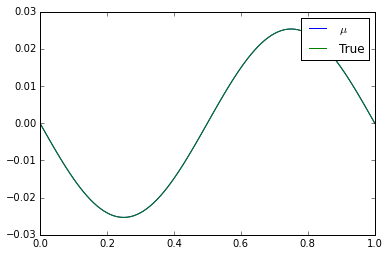

In [59]:
plt.plot(test_points, mu, label='$\mu$')
plt.plot(test_points, -np.sin(2*np.pi*test_points) / (4*np.pi**2), label='True')
plt.legend()

In [61]:
plt.figure(figsize=(10,5))
a = gpanim.animate_gp(test_points.ravel(), mu.ravel(), Sigma, samples=25, plot_kwargs={'c': 'gray', 'alpha':0.5}, jitter=1e-6)
plt.plot(test_points, mu, c='orange', linewidth=2)

for x_pt in interior:
    plt.axvline(x_pt, linestyle='dotted', color='gray')
a

In [ ]:
# interesting to visualise the gradient of this...

<matplotlib.colorbar.Colorbar instance at 0x10a589440>

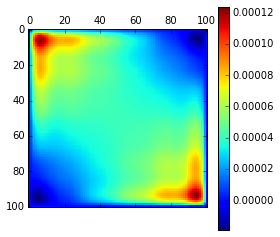

In [11]:
plt.colorbar(plt.matshow(Sigma))

/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  if __name__ == '__main__':


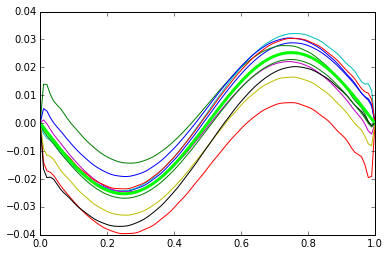

In [37]:
samps = np.random.multivariate_normal(mu.ravel(), Sigma, 10).T
plt.plot(test_points, samps);
plt.plot(test_points, mu, c='lime', linewidth=3)